In [1]:
from functions import *
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorForTokenClassification,  AutoModelForTokenClassification, TrainingArguments, Trainer
import evaluate


# Load in HuggingFace

Récupérer le token Hugging Face

In [ ]:
# Charger les variables d'environnement à partir du fichier .env
load_dotenv()

# Accéder à une variable d'environnement spécifique
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

# Utiliser la variable d'environnement
print("Hugging Face Token:", huggingface_token)

Utiliser ce token pour se login

In [3]:
notebook_login()

# Preprocessing

On charge la base de données 

In [4]:
df = pd.read_csv("../data/dataset.csv", na_filter=False)

On créer un tableau de textes et un de tags associés à partir de notre DataFrame.

In [5]:
texts, tags = create_text_tag_arrays(df)

# Afficher la première ligne des tableaux de textes et de tags, qui correspond au premier individu recensé
print(texts[0], tags[0], sep="\n")

['25', 'Garcon', 'Cyrille', 'francaise', 'menuisier', 'Breton']
['age', 'civil_status', 'firstname', 'nationality', 'occupation', 'surname']


In [6]:
# Tokenization : Séparer les mots avec le schéma de notation B-I

desired_label_order = [
    "B-age",
    "I-age",
    "B-birth_date",
    "I-birth_date",
    "B-civil_status",
    "I-civil_status",
    "B-employer",
    "I-employer",
    "B-firstname",
    "I-firstname",
    "B-link",
    "I-link",
    "B-lob",
    "I-lob",
    "B-nationality",
    "I-nationality",
    "B-observation",
    "I-observation",
    "B-occupation",
    "I-occupation",
    "B-surname",
    "I-surname",
]

new_texts, new_tags = separate_words_with_space(texts, tags)

# Création des dictionnaires de translation entre nouveaux tags et identifiants numériques
tag2id = {tag: id for id, tag in enumerate(desired_label_order)}
id2tag = {id: tag for tag, id in tag2id.items()}
unique_tags_id = [tag2id[tag] for tag in desired_label_order]

In [7]:

train_texts, test_texts, train_tags, test_tags = train_test_split(
    new_texts, new_tags, test_size=0.3 #, stratify=new_tags
)
train_dataset = create_dataset(train_texts, train_tags, desired_label_order)
test_dataset = create_dataset(test_texts, test_tags, desired_label_order)

datasets = DatasetDict({"train": train_dataset, "test": test_dataset})
label_list = datasets["train"].features[f"ner_tags"].feature.names

print(datasets)

Casting the dataset:   0%|          | 0/17813 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7635 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 17813
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7635
    })
})


In [8]:
tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base")

In [9]:
example = datasets["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['<s>',
 '▁42',
 '▁patron',
 '▁Je',
 're',
 'mie',
 '▁idem',
 '▁francaise',
 '▁voit',
 'urier',
 '▁S',
 'ouche',
 '</s>']

In [10]:
example

{'id': '0',
 'tokens': ['42',
  'patron',
  'Jeremie',
  'idem',
  'francaise',
  'voiturier',
  'Souche'],
 'ner_tags': [0, 6, 8, 10, 14, 18, 20]}

In [11]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(
            batch_index=i
        )  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif (
                word_idx != previous_word_idx
            ):  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/17813 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Formatage des données avec DataCollatorForTokenClassification

In [12]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Évaluation du modèle avec seqeval

In [13]:
seqeval = evaluate.load("seqeval")

In [14]:
labels = [label_list[i] for i in example[f"ner_tags"]]

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Model

## FineTuning CamenBERT

### Training 

Executer cette partie pour entraîner et fine-tuner le model camembert-base

In [15]:
model = AutoModelForTokenClassification.from_pretrained(
    "almanach/camembert-base", num_labels=22, id2label=id2tag, label2id=tag2id
)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install accelerate -U # Run and Restart the kernel 

In [17]:
training_args = TrainingArguments(
    output_dir="../models/camenBERT",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=10,
    weight_decay=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.377200,0.224077,0.972595,0.974247,0.973421,0.974500
2,0.116400,0.104052,0.978452,0.980114,0.979282,0.980432
3,0.073100,0.077044,0.981632,0.982877,0.982254,0.983427
4,0.057300,0.071278,0.982658,0.983081,0.982869,0.983201
5,0.047300,0.069777,0.983935,0.984938,0.984436,0.984839
6,0.036000,0.065342,0.984455,0.985436,0.984946,0.985461
7,0.030200,0.066426,0.985331,0.985867,0.985599,0.985687
8,0.022900,0.065909,0.985517,0.986388,0.985952,0.986270
9,0.020300,0.068984,0.985993,0.986909,0.986451,0.986478
10,0.019500,0.067778,0.985992,0.986818,0.986405,0.986459


/opt/mamba/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=17820, training_loss=0.12259896301928862, metrics={'train_runtime': 1811.3401, 'train_samples_per_second': 98.342, 'train_steps_per_second': 9.838, 'total_flos': 1652155030956444.0, 'train_loss': 0.12259896301928862, 'epoch': 10.0})

In [18]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# Transform to id with tag2id
true_labels_int = [[tag2id[tag] for tag in sequence] for sequence in true_labels]
true_predictions_int = [[tag2id[tag] for tag in sequence] for sequence in true_predictions]

## Résultats

In [19]:
results = seqeval.compute(predictions=true_predictions, references=true_labels)

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                   age   birth_date  civil_status    employer    firstname  \
precision     0.997766     0.997725      0.999062    0.953488     0.993170   
recall        0.997969     0.997725      1.000000    0.969595     0.993037   
f1            0.997868     0.997725      0.999531    0.961474     0.993103   
number     4924.000000  2198.000000   3195.000000  888.000000  7468.000000   

                  link          lob  nationality  observation   occupation  \
precision     0.970939     0.969042     0.982806     0.830986     0.964050   
recall        0.985652     0.973599     0.977205     0.617801     0.960280   
f1            0.978240     0.971315     0.979998     0.708709     0.962161   
number     6203.000000  2765.000000  4036.000000   191.000000  4859.000000   

               surname  overall_precision  overall_recall  overall_f1  \
precision     0.994754           0.984455        0.985436    0.984946   
recall        0.996094           0.984455        0.985436    0.984946   

In [24]:
# Afficher le DataFrame en tant que tableau LaTeX
# print(results_df.drop("number").transpose().to_latex())

Matrices de confusion

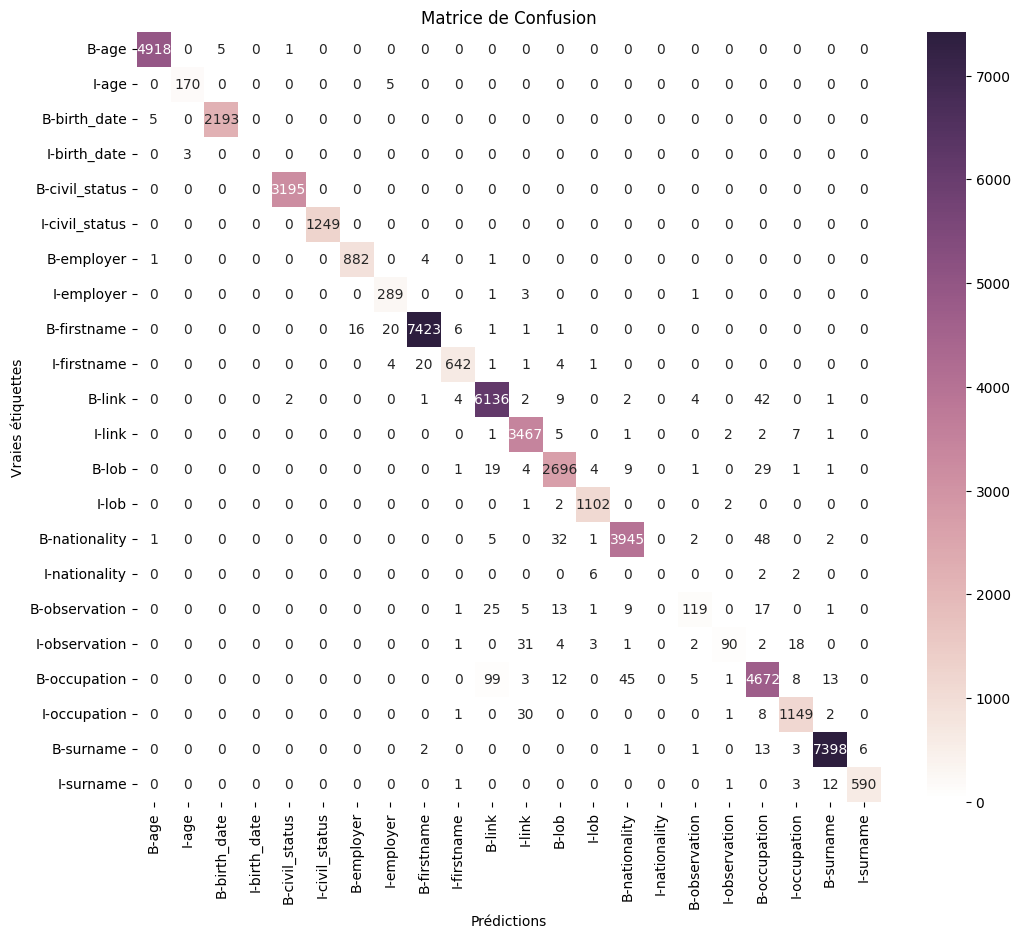

In [21]:
cfm_metric = evaluate.load("BucketHeadP65/confusion_matrix")

# On créer une seule list de labels pour l'ensemble du set
true_predictions_int_flat_list = [item for sublist in true_predictions_int for item in sublist]
true_labels_int_flat_list = [item for sublist in true_labels_int for item in sublist]

# Calcul de la matrice de confusion
cfm_results = cfm_metric.compute(predictions=true_predictions_int_flat_list, references=true_labels_int_flat_list)
conf_df = pd.DataFrame(cfm_results['confusion_matrix'])

# Créer une liste des noms de tags pour les axes x et y
x_labels = [id2tag[i] for i in range(len(id2tag))]
y_labels = [id2tag[i] for i in range(len(id2tag))]

# Afficher la matrice de confusion avec seaborn en utilisant les noms de tags comme légendes
plt.figure(figsize=(12, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(conf_df, annot=True, fmt="d", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.savefig("../img/big_conf_matrix.png", format="png")
plt.show()


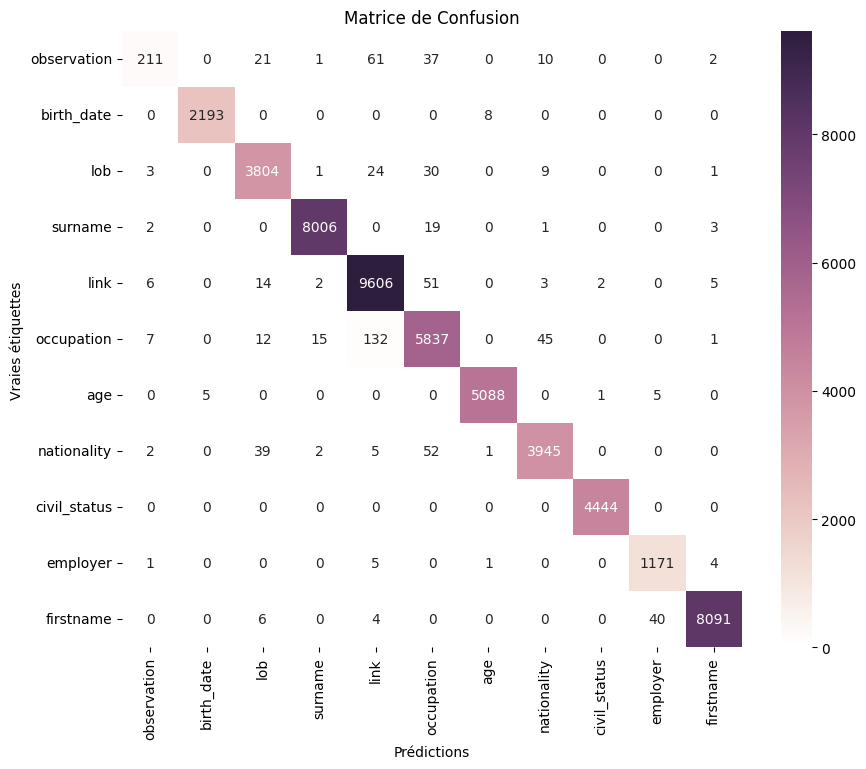

In [22]:
# Fonction pour mapper les étiquettes aux versions de base (sans préfixe B ou I)
def map_labels(label):
    return label.split("-")[-1]

# Appliquer la fonction aux étiquettes
true_labels_base = [[map_labels(tag) for tag in sequence] for sequence in true_labels]
true_predictions_base = [[map_labels(tag) for tag in sequence] for sequence in true_predictions]

# Créer une liste de labels uniques
unique_labels = list(set([label for sublist in true_labels_base for label in sublist]))

# Créer une matrice de confusion pour les labels de base
conf_matrix_base = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

# Remplir la matrice de confusion
for true, pred in zip(true_labels_base, true_predictions_base):
    for i, j in zip(true, pred):
        conf_matrix_base[unique_labels.index(i), unique_labels.index(j)] += 1

# Créer un DataFrame pour la matrice de confusion
conf_df_base = pd.DataFrame(conf_matrix_base, index=unique_labels, columns=unique_labels)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(conf_df_base, annot=True, fmt="d", cmap=cmap)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.savefig("../img/conf_matrix.png", format="png")
plt.show()


Inference

In [23]:
from transformers import pipeline

text = "1911 AnneMarie fille idem 34 couturiere Pelleu"
classifier = pipeline("ner", model="../models/camenBERT")
classifier(text)

[{'entity': 'B-birth_date',
  'score': 0.99752885,
  'index': 1,
  'word': '▁1911',
  'start': 0,
  'end': 4},
 {'entity': 'B-firstname',
  'score': 0.99984074,
  'index': 2,
  'word': '▁Anne',
  'start': 5,
  'end': 9},
 {'entity': 'I-firstname',
  'score': 0.99771535,
  'index': 3,
  'word': 'Marie',
  'start': 9,
  'end': 14},
 {'entity': 'B-link',
  'score': 0.9992305,
  'index': 4,
  'word': '▁fille',
  'start': 15,
  'end': 20},
 {'entity': 'B-lob',
  'score': 0.9971602,
  'index': 5,
  'word': '▁idem',
  'start': 21,
  'end': 25},
 {'entity': 'B-nationality',
  'score': 0.93874305,
  'index': 6,
  'word': '▁34',
  'start': 26,
  'end': 28},
 {'entity': 'B-occupation',
  'score': 0.998792,
  'index': 7,
  'word': '▁couturier',
  'start': 29,
  'end': 38},
 {'entity': 'B-occupation',
  'score': 0.9985839,
  'index': 8,
  'word': 'e',
  'start': 38,
  'end': 39},
 {'entity': 'B-surname',
  'score': 0.9997441,
  'index': 9,
  'word': '▁P',
  'start': 40,
  'end': 41},
 {'entity': 'I